In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle #sklearn has SSL algorithms - Label Propagation and Label Spreading
import pomegranate as pg
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer
import warnings
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.simplefilter('ignore')
np.random.seed(1)

In [3]:
img_height = 224
img_width = 224
ushapes = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_supervised/square_images_size224_cleaned/UShape/"
no_ushapes = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_supervised/square_images_size224_cleaned/NoUshape/"
#ushapes = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_supervised/square_images_size224_cleaned"

In [4]:
def extract_spectrograms(path):
    os.chdir(path)

    spectrograms = []

    with os.scandir(path) as files:
        for file in files:
            #print(file.name)
            if file.name.endswith('.png'):
                spectrograms.append(file.path)
        return spectrograms

ushape_spectrograms = extract_spectrograms(ushapes)
#print('2')
no_ushape_spectrograms = extract_spectrograms(no_ushapes)
total_spectrograms = ushape_spectrograms + no_ushape_spectrograms
#import random
#random.shuffle(total_spectograms)
print(f"total specto: {len(total_spectrograms)}, ushape: {len(ushape_spectrograms)}, noushape: {len(no_ushape_spectrograms)}")
training_size = int(len(total_spectrograms) * 0.01)
testing_size = int(len(total_spectrograms) * 0.25)
unlabeled_size = int(len(total_spectrograms) * .74)
print(f"training size: {training_size}, testing size: {testing_size}, unlabeled size: {unlabeled_size}")

total specto: 3990, ushape: 168, noushape: 3822
training size: 39, testing size: 997, unlabeled size: 2952


In [13]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
 
createFolder('/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/labeled/ushape/')
createFolder('/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/labeled/noushape/')
createFolder('/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/unlabeled/')
createFolder('/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/test/ushape/')
createFolder('/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/test/noushape/')

labeled_ushape_path = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/labeled/ushape/"
labeled_noushape_path = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/labeled/noushape/"
unlabeled_path = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/unlabeled/"
test_ushape_path = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/test/ushape/"
test_noushape_path = r"/Users/seohyeon/Documents/2023-1/lab/space_weather_proj/semi-supervised/dataset_semisupervised/test/noushape/"

In [14]:
#folder

cut_1 = 168/3
cut_2 = 3822/3*0.25

for i, ushape in enumerate(os.listdir(ushapes)):
    if(ushape.endswith('png')):
        if i<cut_1:
            shutil.copy(ushapes + ushape, labeled_ushape_path + ushape)
        elif i>cut_1 and i<cut_1*2:
            shutil.copy(ushapes + ushape, test_ushape_path + ushape)
        elif i>cut_1*2:
            shutil.copy(ushapes + ushape, unlabeled_path + ushape)
            
for i, noushape in enumerate(os.listdir(no_ushapes)):
    if(noushape.endswith('png')):
        if i<cut_2:
            shutil.copy(no_ushapes + noushape, labeled_noushape_path + noushape)
        elif i>cut_2 and i<cut_2*2:
            shutil.copy(no_ushapes + noushape, test_noushape_path + noushape)
        elif i>cut_2*2:
            shutil.copy(no_ushapes + noushape, unlabeled_path + noushape)


In [26]:
labeled_ushape = extract_spectrograms(labeled_ushape_path)
labeled_noushape = extract_spectrograms(labeled_noushape_path)
test_ushape = extract_spectrograms(test_ushape_path)
test_noushape = extract_spectrograms(test_noushape_path)
unlabeled = extract_spectrograms(unlabeled_path)
print(len(labeled_ushape), len(labeled_noushape), len(test_ushape), len(test_noushape))

56 318 55 318


In [122]:
#make dataframe
def fill_df_with_label(spectrograms, label):
    new_df =  pd.DataFrame()
    new_df['filename'] = spectrograms
    new_df['label'] = [label] * len(spectrograms)
    return new_df

df_lb = pd.concat([fill_df_with_label(labeled_ushape, "ushape"),fill_df_with_label(labeled_noushape, "noshape")])
df_test = pd.concat([fill_df_with_label(test_ushape, "ushape"),fill_df_with_label(test_noushape, "noshape")])
df_unlabeled = fill_df_with_label(unlabeled, "-1")
# df_total=pd.concat([df_lb, df_test])
# df_total = df_total.sample(frac=1)
# df_total.describe()

In [42]:
# labeled, unlabeled, test = np.split(df_total, [int(.25*len(df_total)), int(.5*len(df_total))])
# labeled_unlabeled = pd.concat([labeled, unlabeled])
# print(len(labeled), len(unlabeled), len(test))

997 998 1995


In [29]:
import scipy 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
labeled_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

#Generate batches and augment the images
labeled_generator = labeled_datagen.flow_from_dataframe(
    df_lb,
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

Found 374 validated image filenames belonging to 2 classes.
Found 373 validated image filenames belonging to 2 classes.


In [20]:
def create_model(METRICS):
  model = Sequential([
    #data_augmentation,
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=METRICS)
  return model


In [21]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Metal device set to: Apple M1 Pro


In [146]:
epochs = 25
model = create_model(METRICS)
history = model.fit_generator(generator=
  labeled_generator,
  epochs=epochs
)

# fold0_generator = test_datagen.flow_from_dataframe(
#     fold0_dataframe,
#     # directory='harp/validation/',
#     class_mode=None,
#     target_size=(224, 224),
# )
# predictions_0 = model.predict_generator(fold0_generator,np.ceil(len(fold_0)/32))

Epoch 1/25
12/12 [==============================] - 3s 234ms/step - loss: 0.5888 - accuracy: 0.8648 - precision: 0.0800 - recall: 0.0250 - auc: 0.5881 - prc: 0.1469
Epoch 2/25
12/12 [==============================] - 3s 238ms/step - loss: 0.4148 - accuracy: 0.8503 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6126 - prc: 0.1901
Epoch 3/25
12/12 [==============================] - 3s 242ms/step - loss: 0.3929 - accuracy: 0.8503 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6889 - prc: 0.2553
Epoch 4/25
12/12 [==============================] - 3s 239ms/step - loss: 0.3718 - accuracy: 0.8503 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7551 - prc: 0.3260
Epoch 5/25
12/12 [==============================] - 3s 236ms/step - loss: 0.3691 - accuracy: 0.8503 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7571 - prc: 0.3092
Epoch 6/25
12/12 [==============================] - 3s 239ms/step - loss: 0.3686 - accuracy: 0.8503 - precision: 0.0000e+00 - recall: 0.0000e+0

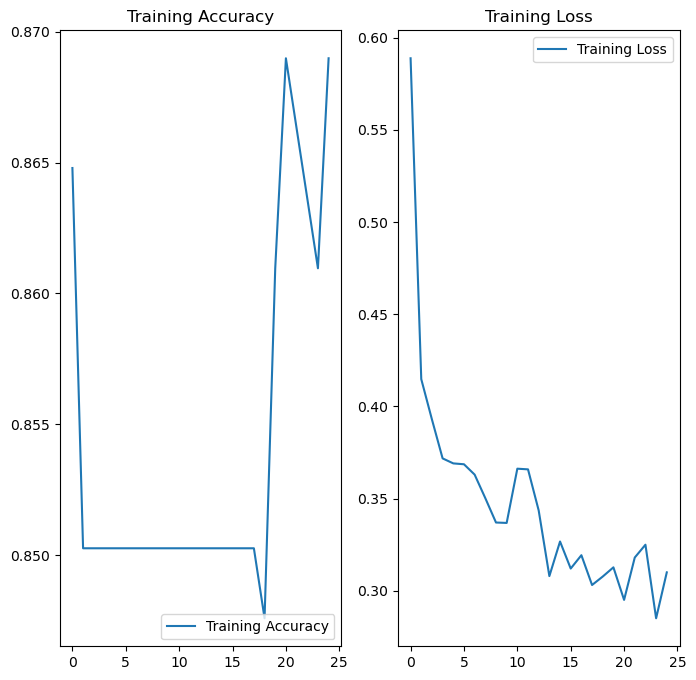

In [149]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [123]:
result = model.predict_generator(test_generator)
# print(test_generator.class_indices)
# print(result)
df = pd.DataFrame()
for i in range(len(result)):
    if result[i]>=0.5:
        df = pd.concat([df, pd.DataFrame(["ushape"])])
    else:
        df = pd.concat([df, pd.DataFrame(["noushape"])])
        
# print(test_generator.class_indices)
# print(result)

In [128]:
df_test = df_test.reset_index()
df = df.reset_index()

In [129]:
df_test

,index,filename,label
0,0,/Users/seohyeon/Documents/2023-1/lab/space_wea...,ushape
1,1,/Users/seohyeon/Documents/2023-1/lab/space_wea...,ushape
2,2,/Users/seohyeon/Documents/2023-1/lab/space_wea...,ushape
3,3,/Users/seohyeon/Documents/2023-1/lab/space_wea...,ushape
4,4,/Users/seohyeon/Documents/2023-1/lab/space_wea...,ushape
...,...,...,...
368,313,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noshape
369,314,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noshape
370,315,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noshape
371,316,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noshape


In [130]:
df

,index,0
0,0,noushape
1,0,noushape
2,0,ushape
3,0,noushape
4,0,noushape
...,...,...
368,0,ushape
369,0,noushape
370,0,noushape
371,0,noushape


In [139]:

print(len(df), len(df_test))
df_pseudo = pd.concat([df_test["filename"], df], axis = 1)
df_pseudo
df_pseudo.drop(["index"], axis = 1, inplace = True)

df_pseudo.rename(columns={0: "label"}, inplace=True)
df_pseudo

373 373


,filename,label
0,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noushape
1,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noushape
2,/Users/seohyeon/Documents/2023-1/lab/space_wea...,ushape
3,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noushape
4,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noushape
...,...,...
368,/Users/seohyeon/Documents/2023-1/lab/space_wea...,ushape
369,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noushape
370,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noushape
371,/Users/seohyeon/Documents/2023-1/lab/space_wea...,noushape


In [140]:
pseudo_generator = test_datagen.flow_from_dataframe(
    df_pseudo,
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

Found 373 validated image filenames belonging to 2 classes.


In [145]:
epochs = 25
model = create_model(METRICS)
history2 = model.fit_generator(generator=
  pseudo_generator,
  epochs=epochs
)

Epoch 1/25
12/12 [==============================] - 4s 232ms/step - loss: 0.5238 - accuracy: 0.9196 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5103 - prc: 0.0623
Epoch 2/25
12/12 [==============================] - 3s 234ms/step - loss: 0.3194 - accuracy: 0.9357 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4672 - prc: 0.0650
Epoch 3/25
12/12 [==============================] - 3s 239ms/step - loss: 0.2560 - accuracy: 0.9357 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5485 - prc: 0.0742
Epoch 4/25
12/12 [==============================] - 3s 235ms/step - loss: 0.2487 - accuracy: 0.9357 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5181 - prc: 0.1065
Epoch 5/25
12/12 [==============================] - 3s 236ms/step - loss: 0.2444 - accuracy: 0.9357 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5101 - prc: 0.0649
Epoch 6/25
12/12 [==============================] - 3s 236ms/step - loss: 0.2452 - accuracy: 0.9357 - precision: 0.0000e+00 - recall: 0

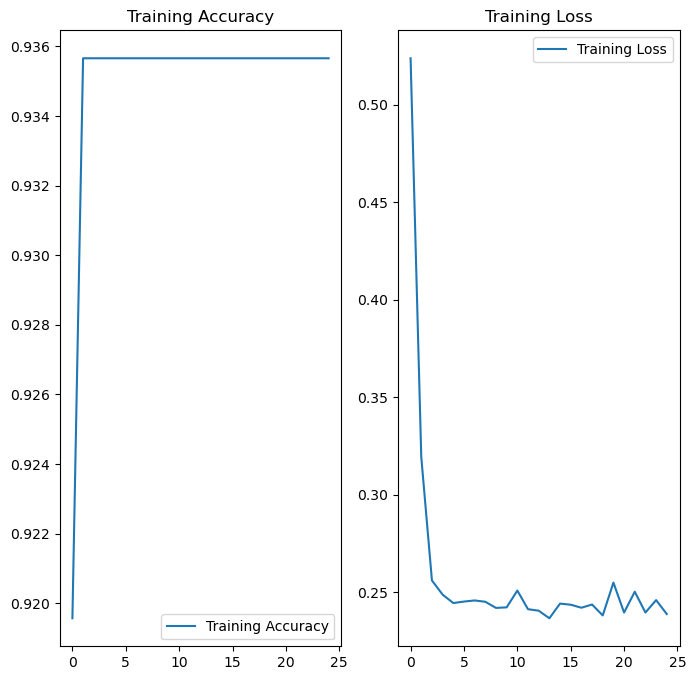

In [148]:
acc = history2.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history2.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()